# Práctica 8: modelos de clasificación de texto usando modelos de lenguaje

En este notebook se muestra cómo crear un modelo de clasificación de texto usando la aproximación [ULMFit](https://nlp.fast.ai/) que viene descrita en el siguiente diagrama.

<img alt="Diagram of the ULMFiT process" width="700" caption="The ULMFiT process" id="ulmfit_process" src="https://github.com/joheras/fastbook/blob/master/images/att_00027.png?raw=1">

En primer lugar es necesario disponer de un modelo de lenguaje entrenado con un dataset de tamaño considerable. En nuestro caso la Wikipedia. Este modelo sirve para conocer los fundamentos del lenguaje con el cual se está trabajando. Sin embargo, a la hora de construir un modelo de clasificación es conveniente que el modelo comprenda el estilo que se usa para escribir esos textos. Dicho estilo puede ser más informal o más técnico que el contenido de la wikipedia. En el caso del dataset IMDb, este va a contener una gran cantidad de nombres de directores, actores, y además el estilo de redacción es más informal que los textos que aparecen en la Wikipedia. Por ello, a partir del modelo de lenguaje de Wikipedia entrenaremos un modelo de lenguaje para IMDb, y a partir de ese modelo de lenguaje construiremos nuestro clasificador.

Afortunadamente la librería FastAI ya proporciona un modelo de lenguaje para la Wikipedia (construir este tipo de modelos puede llevar días), por lo que nos podemos centrar en los otros dos pasos. 

Para esta práctica es necesario el uso de GPU, así que recuerda activar esta opción en Colab. 

## Librerías

Comenzamos actualizando la librería FastAI y descargando la librería datasets de HuggingFace. Al finalizar la instalación deberás reiniciar el kernel (menú Entorno de ejecución -> Reiniciar Entorno de ejecución).

In [1]:
!pip install fastai -Uqq
!pip install datasets -Uqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 1.1 MB/s eta 0:00:00


Cargamos a continuación las librerías que necesitaremos en esta práctica que son la parte de procesado de lenguaje natural de la librería fastAI, la librería pandas, y la funcionalidad para cargar datasets de HuggingFace.

In [2]:
import pandas as pd
from fastai.text.all import *
from datasets import load_dataset

## Dataset

Para este ejemplo vamos a usar el dataset [Gutenberg Poem Dataset](https://huggingface.co/datasets/poem_sentiment), un dataset para detectar sentimientos en poemas (negativos, positivos, sin impacto, mezcla de positivo y negativo).

Descarga el dataset usando el siguiente comando. 

In [3]:
#poem_sentiment_dataset = load_dataset("poem_sentiment")
rt_dataset = load_dataset("rotten_tomatoes")

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Dataset rotten_tomatoes downloaded and prepared to /root/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

## Carga de datos

Cargamos a continuación el dataset en distintos dataframes de pandas (el formato que puede leer la librería de FastAI).

In [4]:
train_df = rt_dataset["train"].to_pandas()
valid_df = rt_dataset["validation"].to_pandas()
test_df = rt_dataset["test"].to_pandas()

A continuación procesamos el dataset como vimos en la práctica anterior para tenerlo en el formato adecuado. 

In [5]:
train_df['set']=False
valid_df['set']=True
train_valid_df = pd.concat([train_df,valid_df])

## Modelo de lenguaje

El proceso a seguir para hacer fine-tuning sobre el modelo de lenguaje de FastAI es análogo al visto en prácticas anteriores. Comenzamos creando un `DataBlock` a partir de nuestro dataframe. 

In [6]:
db_lm = DataBlock(
    blocks=TextBlock.from_df('text', is_lm=True,max_vocab=100000), # Indicamos que vamos a trabajar con un modelo de lenguaje
    get_items=ColReader('text'), # Indicamos donde estará el texto dentro del dataframe
    splitter=RandomSplitter(0.1) # Partimos el dataset en entrenamiento y validación
)

Creamos ahora nuestro `dataloader` (esto puede llevar varios segundos).

In [7]:
dls_lm = db_lm.dataloaders(train_valid_df, bs=128, seq_len=80)

Podemos ahora mostrar un batch de este `dataloader`. Como podemos apreciar, la entrada del modelo es una frase, y la salida es dicha frase desplazada una posición a la derecha.

In [8]:
dls_lm.show_batch(max_n=2)

,text,text_
0,"xxbos it 's a beautiful film , full of elaborate and twisted characters - and it 's also pretty funny . xxbos this rather superficial arthouse middle - brow film knows how to please a crowd , and that 's about all it does well . xxbos it 's bright , pristine style and bold colors make it as much fun as reading an xxunk picture book before xxunk . xxbos the best of the xxunk brosnan james bond films","it 's a beautiful film , full of elaborate and twisted characters - and it 's also pretty funny . xxbos this rather superficial arthouse middle - brow film knows how to please a crowd , and that 's about all it does well . xxbos it 's bright , pristine style and bold colors make it as much fun as reading an xxunk picture book before xxunk . xxbos the best of the xxunk brosnan james bond films to"
1,". xxbos [ fessenden ] is much more into ambiguity and creating mood than he is for on screen thrills xxbos best of all is garcia , who perfectly portrays the desperation of a very insecure man . xxbos ' . . . the film 's considered approach to its subject matter is too calm and thoughtful for agitprop , and the xxunk of its characterizations makes it a failure as straight drama . ' xxbos xxunk xxunk ! just","xxbos [ fessenden ] is much more into ambiguity and creating mood than he is for on screen thrills xxbos best of all is garcia , who perfectly portrays the desperation of a very insecure man . xxbos ' . . . the film 's considered approach to its subject matter is too calm and thoughtful for agitprop , and the xxunk of its characterizations makes it a failure as straight drama . ' xxbos xxunk xxunk ! just like"


Creamos ahora nuestro `Learner`.

In [9]:
learn = language_model_learner(
    dls_lm, # El dataloader que usamos
    AWD_LSTM, # La arquitectura que es la misma usada en la práctica anterior
    drop_mult=0.3, # Aplicamos dropout para evitar el sobreajuste
    metrics=[accuracy, Perplexity()] # Como métricas usamos la accuracy y la perplexity.
).to_fp16()

Y por último entrenamos el modelo. 

SuggestedLRs(valley=0.007585775572806597)

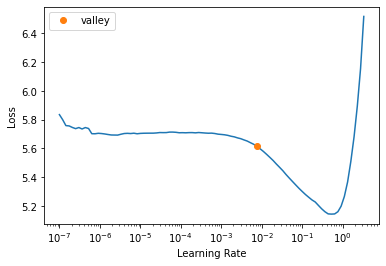

In [10]:
learn.lr_find()

In [11]:
learn.fine_tune(10,base_lr=7e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.401297,4.682523,0.218131,108.042343,00:15


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.531574,4.260525,0.272338,70.847153,00:16
1,4.373609,4.144782,0.283811,63.103867,00:14
2,4.251431,4.063403,0.293757,58.171913,00:15
3,4.125958,4.023700,0.297613,55.907597,00:15
4,3.997221,4.000095,0.300991,54.603355,00:16
5,3.883394,3.999097,0.300857,54.548851,00:15
6,3.771664,4.008920,0.301845,55.087330,00:15
7,3.675366,4.016266,0.301649,55.493526,00:15
8,3.598843,4.020637,0.302065,55.736599,00:16
9,3.547773,4.021619,0.301566,55.791378,00:15


Una vez entrenado el modelo guardamos el `encoder` que usaremos luego para nuestro modelo de clasificación (esto es análogo a lo que vimos para los modelos de clasificación de imágenes).

In [12]:
learn.save_encoder('finetuned')

## Entrenando un modelo de clasificación

Pasamos ahora a crear nuestro modelo de clasificación de texto. El proceso será el mismo que el que vimos en la práctica anterior con la diferencia de que antes de empezar a entrenar el modelo cargaremos el `encoder` guardado en el paso anterior.

Comenzamos definiendo un `DataBlock` que se creará a partir de nuestro dataframe `df`.  

In [13]:
rt_clas = DataBlock(
    blocks=(TextBlock.from_df('text', vocab=dls_lm.vocab), # La entrada del modelo es texto usando el mismo 
                                                           # vocabulario que en el modelo de lenguaje 
            CategoryBlock), #, y la salida una clase 
    get_x=ColReader('text'),  # Indicamos donde estará el texto dentro del dataframe
    get_y=ColReader('label'), # Indicamos cómo extraer la clase del dataframe
    splitter=ColSplitter('set') # Partimos el dataset en entrenamiento y validación
)

Ahora definimos nuestro dataloader a partir del DataBlock que acabamos de crear. 

In [14]:
dls = rt_clas.dataloaders(train_valid_df, bs=64)

Podemos mostrar un batch de nuestro dataloader. 

In [15]:
dls.show_batch(max_n=2)

,text,category
0,"xxbos who are ' they ' ? well , they 're ' they ' . they 're the xxunk , easily xxunk forces that serve as whatever terror the heroes of horror movies try to avoid . they exist for xxunk lines like "" they 're back ! "" , "" they 're out there ! "" and "" they 're coming ! """,0
1,"xxbos . . . a sour little movie at its core ; an exploration of the emptiness that xxunk the relentless xxunk of the xxunk 's . . . the film 's ending has a "" what was it all for ? "" feeling to it , but like the xxunk 's , the trip there is a great deal of fun .",1


Pasamos ahora a crear nuestro `learner` usando el método `text_classifier_learner` al que pasamos como arquitectura de red la arquitectura [AWD_LSTM](https://arxiv.org/abs/1708.02182), además aplicamos dropout a nuestro modelo. 

In [16]:
callbacks = [ShowGraphCallback(),
             SaveModelCallback()]

learnClass = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy,cbs=callbacks).to_fp16()

Cargamos a continuación el `encoder` del modelo de lenguaje. 

In [17]:
learnClass = learnClass.load_encoder('finetuned')

Ahora podemos utilizar toda la funcionalidad que ya vimos para clasificación de imágenes. Por ejemplo, podemos buscar un learning rate adecuado para entrenar nuestro modelo. 

SuggestedLRs(valley=0.005248074419796467)

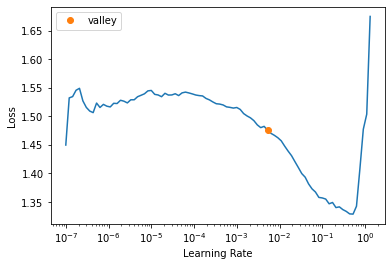

In [18]:
learnClass.lr_find()

Y a continuación aplicar fine tuning. 

epoch,train_loss,valid_loss,accuracy,time
0,1.377918,0.986888,0.657143,00:01


Better model found at epoch 0 with valid_loss value: 0.9868877530097961.


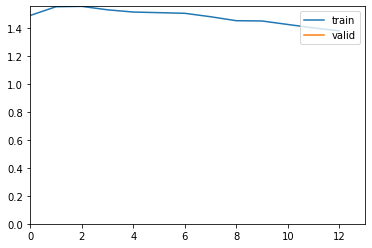

epoch,train_loss,valid_loss,accuracy,time
0,1.059254,0.926006,0.657143,00:01
1,0.959685,0.898782,0.676190,00:01
2,0.927699,1.215786,0.533333,00:01
3,0.854525,1.232314,0.695238,00:01
4,0.751512,1.513104,0.647619,00:03
5,0.660461,1.323592,0.561905,00:01
6,0.563719,1.316423,0.609524,00:01
7,0.468344,1.301857,0.657143,00:01
8,0.387653,1.266303,0.628571,00:01
9,0.329103,1.277086,0.619048,00:01


Better model found at epoch 0 with valid_loss value: 0.9260060787200928.


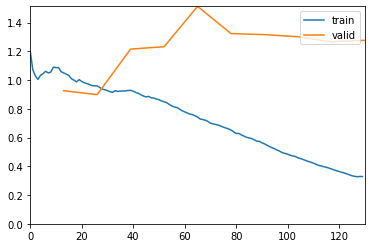

Better model found at epoch 1 with valid_loss value: 0.8987815380096436.


In [19]:
learnClass.fine_tune(10, 6e-2)

Ahora podemos usar nuestro modelo para predecir la clase de una nueva frase. 

In [20]:
learnClass.predict('with pale blue berries. in these peaceful shades--.')

('2', tensor(2), tensor([0.1290, 0.1927, 0.6217, 0.0566]))

Por último, podemos validar nuestro modelo en el conjunto de test, para lo cuál hay que combinar los dataframes y construir un nuevo dataloader. 

In [21]:
test_df['set']=True
test_df = test_df.drop(columns=['id'],axis=1)
train_test_df = pd.concat([train_df,test_df])
train_test_df = train_test_df.rename(columns={"verse_text": "text"})
dls_test = sentiment_clas.dataloaders(train_test_df, bs=64)

Modificamos ahora el dataloader de nuestro learner, y procedemos a validar.

In [22]:
learnClass.dls = dls_test
learnClass.validate()

Better model found at epoch 0 with valid_loss value: 0.6538461446762085.


(#2) [0.9758269190788269,0.6538461446762085]

Hemos obtenido un modelo con una accuracy del 69% (un 3% mejor que sin aplicar la técnica de self-supervised learning). 